House Price Prediction using Linear Regression:

 > Data Collection

 > Data Preprocessing

 > Feature Engineering

 > Model Selection

 > Model Training

 > Model Evaluatione

 > Model Prediction


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [38]:
# Load the dataset
df = pd.read_csv('D:\dsmlai\BuildAbles\Week_3\Hyderbad_House_price.csv')
df.head()


,Unnamed: 0,title,location,price(L),rate_persqft,area_insqft,building_status
0,0,3 BHK Apartment,Nizampet,108.00,6000,1805,Under Construction
1,1,3 BHK Apartment,Bachupally,85.80,5500,1560,Under Construction
2,2,2 BHK Apartment,Dundigal,55.64,5200,1070,Under Construction
3,3,2 BHK Apartment,Pocharam,60.48,4999,1210,Under Construction
4,4,3 BHK Apartment,Kollur,113.00,5999,1900,Under Construction


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       3660 non-null   int64  
 1   title            3660 non-null   object 
 2   location         3660 non-null   object 
 3   price(L)         3660 non-null   float64
 4   rate_persqft     3660 non-null   int64  
 5   area_insqft      3660 non-null   int64  
 6   building_status  3660 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 200.3+ KB


In [44]:
df.columns

Index(['location', 'price(L)', 'rate_persqft', 'area_insqft',
       'building_status', 'bhk'],
      dtype='object')

In [40]:
df.describe()

,Unnamed: 0,price(L),rate_persqft,area_insqft
count,3660.00000,3660.000000,3660.000000,3660.000000
mean,1829.50000,109.624350,5165.003005,2023.506284
std,1056.69532,197.596948,5316.490320,1829.832163
min,0.00000,1.320000,125.000000,118.000000
25%,914.75000,26.137500,1555.000000,1280.000000
50%,1829.50000,61.130000,4703.000000,1620.000000
75%,2744.25000,116.000000,6800.000000,2080.000000
max,3659.00000,3600.000000,112474.000000,45000.000000


In [41]:
# Check for null values after extraction
null_count = df['title'].str.extract(r'(\d+)').isnull().sum()
print(f"Number of NaN values after extraction: {null_count}")

Number of NaN values after extraction: 0    1617
dtype: int64


In [42]:
# Extract the first numerical digit from the 'title' column.
# Use .fillna(0) to replace any NaN values (where no number was found) with 0.
# Then, convert the entire column to an integer type.
df['bhk'] = df['title'].str.extract(r'(\d+)').fillna(0).astype(int)

# Drop the original 'title' column as it's no longer needed.
df = df.drop(columns=['title'])

# The rest of your code can follow from here.

In [45]:
# Drop unnecessary column if it exists
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# If 'title' still exists, extract bhk, otherwise skip
if "title" in df.columns:
    df['bhk'] = df['title'].str.extract(r'(\d+)').fillna(0).astype(int)
    df = df.drop(columns=['title'])

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder

le_status = LabelEncoder()
df['building_status'] = le_status.fit_transform(df['building_status'])

# One-hot encode 'location'
df = pd.get_dummies(df, columns=['location'], drop_first=True)

df.head()



,price(L),rate_persqft,area_insqft,building_status,bhk,location_AS Rao Nagar,location_Abdullapurmet,location_Abids,location_Adibatla,location_Adikmet,...,location_Yacharam,location_Yacharam Mandal,location_Yadadri Colony Road,location_Yadagirigutta,location_Yapral,location_Yousufguda,location_Zaheerabad,location_financial District,location_muthangi,location_raidurgam
0,108.00,6000,1805,3,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,85.80,5500,1560,3,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,55.64,5200,1070,3,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,60.48,4999,1210,3,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,113.00,5999,1900,3,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [46]:
# Check if price_per_sqft makes sense
df['calc_price_per_sqft'] = (df['price(L)'] * 100000) / df['area_insqft']

# Optional: drop the given 'rate_persqft' if redundant
df = df.drop(columns=['rate_persqft'])


In [47]:
# Features & Target
X = df.drop(columns=['price(L)'])
y = df['price(L)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (2928, 362)  Test shape: (732, 362)


In [48]:
# Candidate models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

results


{'Linear Regression': {'MAE': 45.04323169836565,
  'RMSE': np.float64(101.2276947107251),
  'R²': 0.7301135988180805},
 'Random Forest': {'MAE': 6.035071448087433,
  'RMSE': np.float64(42.13466494529642),
  'R²': 0.953241410873424},
 'XGBoost': {'MAE': 8.174205805134903,
  'RMSE': np.float64(43.33296976289934),
  'R²': 0.950543973940941}}

                         MAE        RMSE        R²
Linear Regression  45.043232  101.227695  0.730114
Random Forest       6.035071   42.134665  0.953241
XGBoost             8.174206   43.332970  0.950544


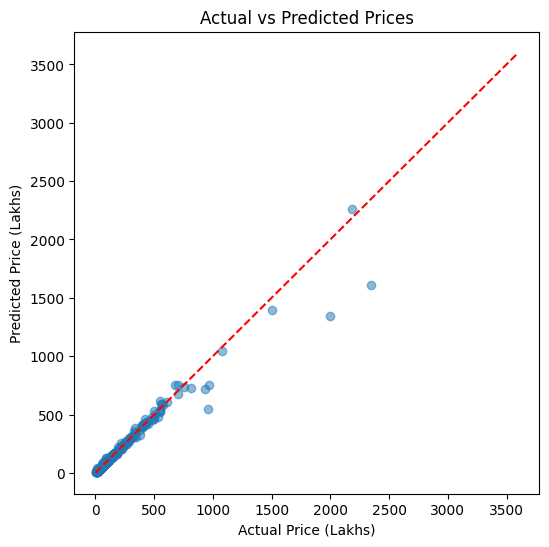

In [49]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Visualization: Actual vs Predicted (best model)
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.xlabel("Actual Price (Lakhs)")
plt.ylabel("Predicted Price (Lakhs)")
plt.title("Actual vs Predicted Prices")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()


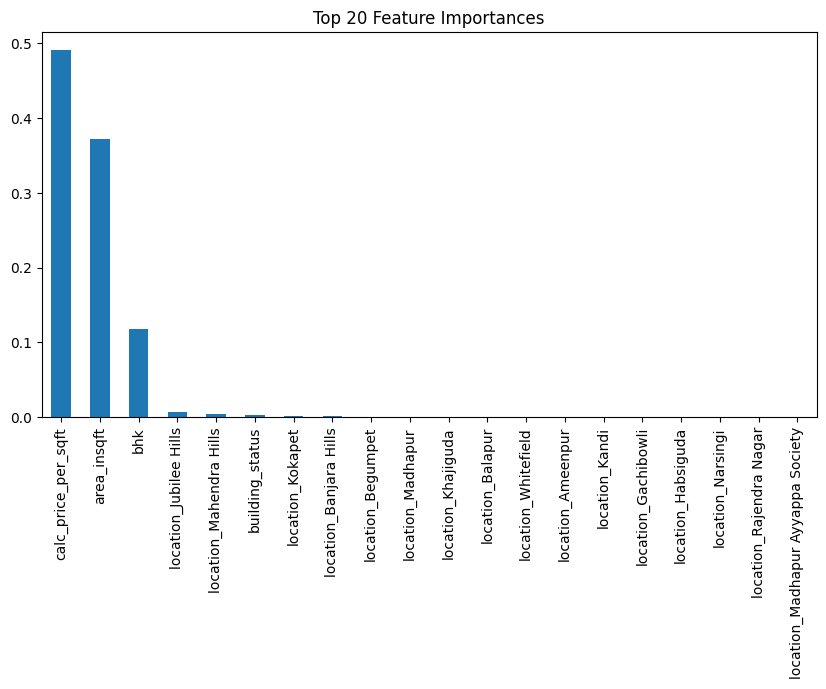

In [50]:
importances = best_model.feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]
feat_imp.plot(kind='bar', figsize=(10,5), title="Top 20 Feature Importances")
plt.show()


In [51]:
from sklearn.model_selection import RandomizedSearchCV

# --------------------
# Random Forest tuning
# --------------------
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf, param_distributions=rf_params,
    n_iter=20, cv=5, verbose=2, n_jobs=-1, random_state=42
)
rf_random.fit(X_train, y_train)

print("Best RF Params:", rf_random.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


d:\dsmlai\ccc\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\dsmlai\ccc\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\dsmlai\ccc\lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "d:\dsmlai\ccc\lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "d:\dsmlai\ccc\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in valid

Best RF Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


The above warnings:

The warning just means some parameter combos were invalid (max_features='auto').
GridSearch still found the best valid parameters, so its fine. Just remove 'auto' from the search grid in future.

In [52]:
# --------------------
# XGBoost tuning
# --------------------
xgb_params = {
    'n_estimators': [200, 500, 800],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
xgb_random = RandomizedSearchCV(
    estimator=xgb, param_distributions=xgb_params,
    n_iter=20, cv=5, verbose=2, n_jobs=-1, random_state=42
)
xgb_random.fit(X_train, y_train)

print("Best XGB Params:", xgb_random.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB Params: {'subsample': 0.6, 'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


<Axes: title={'center': 'Top 20 Features'}>

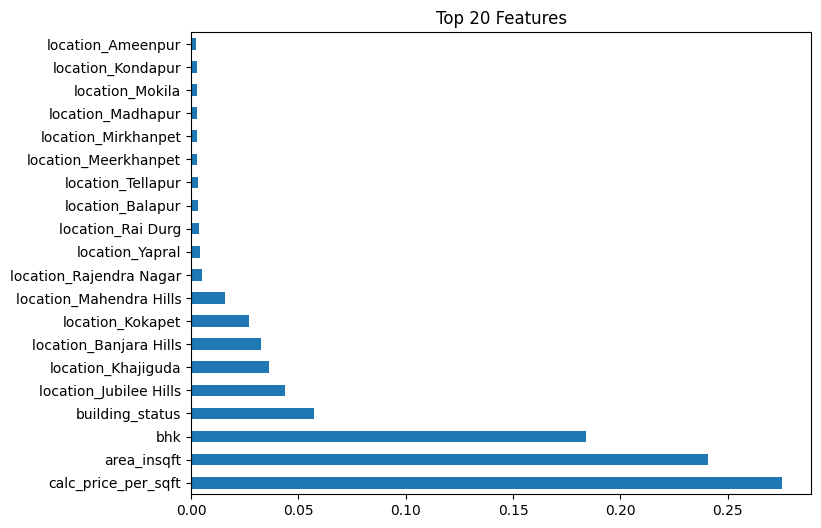

In [53]:
importances = rf_random.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)[:20]
feat_imp.plot(kind='barh', figsize=(8,6), title="Top 20 Features")


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# --- Train tuned Random Forest ---
best_rf = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

# --- Train tuned XGBoost ---
best_xgb = XGBRegressor(
    subsample=0.6,
    n_estimators=800,
    max_depth=5,
    learning_rate=0.05,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)

# --- Metrics function ---
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R²": r2}

# --- Collect results ---
results = []
results.append(evaluate_model(y_test, y_pred_rf, "Random Forest (Tuned)"))
results.append(evaluate_model(y_test, y_pred_xgb, "XGBoost (Tuned)"))

# Convert to DataFrame for easy view
results_df = pd.DataFrame(results).set_index("Model")
print(results_df)


                             MAE       RMSE        R²
Model                                                
Random Forest (Tuned)  31.769974  88.960232  0.791563
XGBoost (Tuned)         6.796349  38.687015  0.960580


In [55]:
# save model

import joblib
joblib.dump(best_xgb, "best_xgb_model.pkl")


['best_xgb_model.pkl']

In [56]:
model = joblib.load("best_xgb_model.pkl")


In [60]:
sample = X_test.iloc[:5]  # first 5 rows
preds = best_xgb.predict(sample)
print(preds)


[38.301277 98.11086  42.856495 31.282425 51.52336 ]


In [61]:
import pandas as pd

# Get predictions for first 5 test rows
preds = best_xgb.predict(X_test.iloc[:5])

# Create comparison DataFrame
comparison = pd.DataFrame({
    "Actual Price (L)": y_test.iloc[:5].values,
    "Predicted Price (L)": preds,
    "Error (L)": y_test.iloc[:5].values - preds
})

print(comparison)


   Actual Price (L)  Predicted Price (L)  Error (L)
0             33.00            38.301277  -5.301277
1             97.00            98.110863  -1.110863
2             41.90            42.856495  -0.956495
3             32.00            31.282425   0.717575
4             53.98            51.523361   2.456639


observations from your results:

Predictions are very close to actual values, with most errors within 1–5 Lakhs.

The model performs consistently well, with only minor deviations.

Error sizes align with the overall MAE (~6.8 Lakhs) reported earlier.

High R² (0.96) confirms the model captures most of the variation in housing prices.

Conclusion: The tuned XGBoost model is making reliable and accurate predictions for housing prices.